In [ ]:
from hdbcli import dbapi
import pandas as pd
import seaborn as sns

In [ ]:
connection = dbapi.connect('18.202.247.58', 39015, 'SYSTEM', 'Glorp2018!')
connection.isconnected()

In [ ]:
cursor = connection.cursor()

# Teil 1 - Import t3n data into HANA
## Aufgaben 1/ 2 / 3/ 4

In [ ]:
# data preparation
t3n_data = pd.read_csv('../praktikum1/t3n_data_spider.csv', encoding='utf8')
t3n_df = t3n_data.dropna()
t3n_df = t3n_df.replace('\n','', regex=True)
t3n_df.head()

In [ ]:
# drop table
sql = 'DROP TABLE T3N'
cursor.execute(sql)

In [ ]:
def create_table():
    sql = 'CREATE COLUMN TABLE \"SYSTEM\".\"T3N\" (\"ID\" VARCHAR(500),\"HEADING\" VARCHAR(2000),\"CATEGORY\" VARCHAR(2000),\"TEASER\" VARCHAR(5000),\"TEXT\" CLOB MEMORY THRESHOLD 1000,\"URL\" VARCHAR(2000), PRIMARY KEY (\"ID\"))'
    cursor.execute(sql)

In [ ]:
def get_escaped_string(string):
    return '\'' + str(string) + '\''

In [ ]:
def insert_data():
    for index, row in t3n_df.iterrows():
        sql_insert_datapoint = 'insert into \"SYSTEM\".\"T3N\" (ID, HEADING, CATEGORY, TEASER, TEXT, URL) VALUES (' + get_escaped_string(row['id']) + ', ' + get_escaped_string(row['heading']) +', ' + get_escaped_string(row['category']) + ',' + get_escaped_string(row['teaser']) + ', ' + get_escaped_string(row['text']) + ', ' + get_escaped_string(row['url'])+ ')'
        print(sql_insert_datapoint)
        #print(row['heading'])
        cursor.execute(sql_insert_datapoint)

In [ ]:
create_table()
insert_data()

## Aufgaben 5/ 6

In [ ]:
# CONFIGURATION 'LINGANALYSIS_BASIC'
sql = 'CREATE FULLTEXT INDEX "T3NTEXTIND" ON "SYSTEM"."T3N" ("TEXT") CONFIGURATION \'LINGANALYSIS_BASIC\' ASYNC LANGUAGE DETECTION (\'de\', \'en\') TEXT ANALYSIS ON'
cursor.execute(sql)

In [ ]:
# CONFIGURATION 'LINGANALYSIS_STEMS'
sql = 'CREATE FULLTEXT INDEX "T3NTEXTIND" ON "SYSTEM"."T3N" ("TEXT") CONFIGURATION \'LINGANALYSIS_STEMS\' ASYNC LANGUAGE DETECTION (\'de\', \'en\') TEXT ANALYSIS ON'
cursor.execute(sql)

In [ ]:
# CONFIGURATION 'LINGANALYSIS_FULL' 
sql = 'CREATE FULLTEXT INDEX "T3NTEXTIND" ON "SYSTEM"."T3N" ("TEXT") CONFIGURATION \'LINGANALYSIS_FULL\' ASYNC LANGUAGE DETECTION (\'de\', \'en\') TEXT ANALYSIS ON'
cursor.execute(sql)

In [ ]:
# drop index
sql = 'DROP FULLTEXT INDEX "T3NTEXTIND";'
cursor.execute(sql)

# Teil 2 mit SQL
## Aufgabe 1
### SQL-View

In [ ]:
# drop SQL-View
sql_drop_view = 'drop view COUNT_NOUNS'
cursor.execute(sql_drop_view)

In [ ]:
# nouns per document
sql = 'create view COUNT_NOUNS as select ID, TA_TOKEN, count(*) as COUNT from "$TA_T3NTEXTIND" where TA_TYPE=\'noun\' group by ID, TA_TOKEN'
cursor.execute(sql)

### Nouns per document

In [ ]:
def plot_nouns(nouns_df):
    ax = sns.distplot(nouns_df['count'])
    ax.set(xlabel='#nouns per document')
    ax.set_title('Nouns per document')
    fig = ax.get_figure()
    fig.savefig('plots/nouns_per_document_t3n.png')

#### Using SQL-View

In [ ]:
# nouns for all documents
cursor.execute('select ID, sum(COUNT) from COUNT_NOUNS group by ID order by sum(COUNT) desc')
nouns_list = cursor.fetchall()
nouns_df = pd.DataFrame(nouns_list)
nouns_df.columns = ['doc', 'count']
nouns_df.head()

In [ ]:
plot_nouns(nouns_df)

In [ ]:
# nouns for a specific document
cursor.execute('select * from COUNT_NOUNS')
nouns_list = cursor.fetchall()
nouns_df = pd.DataFrame(nouns_list)
nouns_df.head(20)

#### Without SQL-View

In [ ]:
# nouns for all documents
cursor.execute('select ID, count(*) from "$TA_T3NTEXTIND" where TA_TYPE=\'noun\' group by ID order by count(*) desc')
nouns_list = cursor.fetchall()
nouns_df = pd.DataFrame(nouns_list)
nouns_df.columns = ['doc', 'count']
nouns_df.head()

In [ ]:
plot_nouns(nouns_df)

In [ ]:
# nouns for a specific document
cursor.execute('select ID, TA_TOKEN, count(*) from "$TA_T3NTEXTIND" where TA_TYPE=\'noun\' group by ID, TA_TOKEN')
nouns_list = cursor.fetchall()
nouns_df = pd.DataFrame(nouns_list)
nouns_df.head(20)

## Aufgabe 2
### Size of Lexica

In [ ]:
cursor.execute('select count(distinct TA_TOKEN) from "$TA_T3NTEXTIND"')
nouns_list = cursor.fetchall()
lexica_size = pd.DataFrame(nouns_list)
lexica_size.columns = ['size']
lexica_size

### Size of Lexica without punctuation and stopwords

In [ ]:
import nltk as nltk
from nltk.corpus import stopwords

def remove_stopwords(data):
    nltk.download('stopwords')
    german_stopwords = set(stopwords.words('german'))
    data['TOKEN_LOW'] = data['TOKEN'].map(lambda row: str(row).lower())
    filtered = []
    for index, row in data.iterrows():
        if row.TOKEN_LOW not in german_stopwords:
            filtered.append(row.TOKEN_LOW)
    filtered_lexica = pd.DataFrame(filtered)
    filtered_lexica.columns = ['TOKEN']
    return filtered_lexica

In [ ]:
cursor.execute('select distinct TA_TOKEN from "$TA_T3NTEXTIND" where TA_TYPE <> \'punctuation\' and TA_TYPE <> \'number\'')
lexica_list = cursor.fetchall()
lexica_df = pd.DataFrame(lexica_list)
lexica_df.columns = ['TOKEN']
lexica_df.size

In [ ]:
filtered_lexica = remove_stopwords(lexica_df)
filtered_lexica.size

### Mean length of a document

In [ ]:
# nouns per document
sql = 'create view COUNT_TOKEN as select ID, count(*) as COUNT from "$TA_T3NTEXTIND" group by ID order by count(*) desc'
cursor.execute(sql)

In [ ]:
# drop SQL-View
sql_drop_view = 'drop view COUNT_TOKEN'
cursor.execute(sql_drop_view)

In [ ]:
cursor.execute('select avg(COUNT) from COUNT_TOKEN')
mean_length_doc = cursor.fetchall()
mean_length_doc = pd.DataFrame(mean_length_doc)
mean_length_doc.columns = ['AVERAGE']
mean_length_doc

### Mean length of a sentence

In [ ]:
cursor.execute('select AVG(TA_SENTENCE) as AVG_SENTENCE from "$TA_T3NTEXTIND" order by AVG(TA_SENTENCE) desc')
mean_length_sentence = cursor.fetchall()
mean_length_sentence_df = pd.DataFrame(mean_length_sentence)
mean_length_sentence_df_new = mean_length_sentence_df.dropna()
mean_length_sentence_df_new.columns = ['AVERAGE']
mean_length_sentence_df_new.head()

## Aufgabe 3
### Word frequency

In [ ]:
cursor.execute('select TA_TOKEN, count(*) from "$TA_T3NTEXTIND" group by TA_TOKEN order by count(*) desc')
words_list = cursor.fetchall()
words_df = pd.DataFrame(words_list)
words_df.columns = ['TOKEN', 'count']
words_df

In [ ]:
# with filtered_lexica (removed punctuation and number)
cursor.execute('select TA_TOKEN, count(*) from "$TA_T3NTEXTIND" where TA_TYPE <> \'punctuation\' and TA_TYPE <> \'number\' group by TA_TOKEN order by count(*) desc')
lexica_list = cursor.fetchall()
lexica_df = pd.DataFrame(lexica_list)
lexica_df.columns = ['TOKEN', 'count']
lexica_df

### Frequent and rare words

In [ ]:
# frequent words
cursor.execute('select TA_TOKEN, count(*) from "$TA_T3NTEXTIND" where TA_TYPE = \'noun\' or TA_TYPE = \'verb\' or TA_TYPE = \'adjective\' group by TA_TOKEN order by count(*) desc')
words_list = cursor.fetchall()
words_df = pd.DataFrame(words_list)
words_df.columns = ['TA_TOKEN', 'count']
sns.set(rc={'figure.figsize':(27,7)})
ax = sns.barplot(x="TA_TOKEN", y="count", data=words_df.head(20))
fig = ax.get_figure()
fig.savefig('plots/barplot_words_freq_t3n.png')

In [ ]:
# rare words
words_df.tail(20)

### Restriction to POS-Tags, categories or documents

In [ ]:
# restriction to nouns
# barplot
cursor.execute('select top 20 TA_TOKEN, count(*) from "$TA_T3NTEXTIND" where TA_TYPE=\'noun\' group by TA_TOKEN order by count(*) desc')
results_words = cursor.fetchall()
results_words_df = pd.DataFrame(results_words)
results_words_df.columns = ['TA_TOKEN', 'count']
sns.set(rc={'figure.figsize':(27,7)})
ax = sns.barplot(x="TA_TOKEN", y="count", data=results_words_df)
fig = ax.get_figure()
fig.savefig('plots/barplot_nouns_t3n.png')

In [ ]:
from wordcloud import WordCloud 
import matplotlib.pyplot as plt
tmpDict = {}
cursor.execute('SELECT top 20 TA_TOKEN, count(*) from "$TA_T3NTEXTIND" where TA_TYPE=\'noun\' group by TA_TOKEN order by count(*) desc')
for row in cursor: 
    tmpDict[row[0]]=row[1]
wordcloud = WordCloud(width=480, height=480, margin=0).generate_from_frequencies(tmpDict) 
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()
wordcloud.to_file('plots/wordcloud_nouns_t3n.png')

In [ ]:
# restriction to category
# frequent words (only nouns) of category Marketing
cursor.execute('select top 10 TA_TOKEN, count(*) from "$TA_T3NTEXTIND", "T3N" where "$TA_T3NTEXTIND".ID = "T3N".ID and "T3N".CATEGORY = \'Marketing\' and TA_TYPE=\'noun\' group by TA_TOKEN order by count(*) desc')
words_list = cursor.fetchall()
results_words_df = pd.DataFrame(words_list)
results_words_df.columns = ['TA_TOKEN', 'count']
sns.set(rc={'figure.figsize':(27,7)})
ax = sns.barplot(x="TA_TOKEN", y="count", data=results_words_df)
fig = ax.get_figure()
fig.savefig('plots/barplot_marketing_t3n.png')

## Aufgabe 4

### Ambiguity of words

In [ ]:
# create view
cursor.execute('create view POSTAGS as select TA_NORMALIZED as nor, ID as id, TA_TYPE as type, count(*) as count_words from "$TA_T3NTEXTIND" where TA_TYPE = \'noun\' or TA_TYPE = \'verb\' or TA_TYPE = \'adjective\' group by TA_NORMALIZED, ID, TA_TYPE having count(*)>1')

In [ ]:
# drop SQL-View
sql_drop_view = 'drop view POSTAGS'
cursor.execute(sql_drop_view)

In [ ]:
cursor.execute('select NOR, ID, count(NOR) from POSTAGS group by NOR, ID having count(NOR) > 1 order by count(NOR) desc')
words_list = cursor.fetchall()
words_df = pd.DataFrame(words_list)
df = words_df.dropna()
df.head(30)

## Aufgabe 5

### 1. Statistics

In [ ]:
# frequent adjectives
cursor.execute('SELECT top 10 TA_TOKEN, count(*) from "$TA_T3NTEXTIND" where TA_TYPE=\'adjective\' group by TA_TOKEN order by count(*) desc')
words_top_20 = cursor.fetchall()
words_top_20_df = pd.DataFrame(words_top_20)
words_top_20_df.columns = ['adjective', 'count']
words_top_20_df.head(20)

sns.set(rc={'figure.figsize':(17,7)})
sns.set(style="whitegrid")
ax = sns.barplot(x="adjective", y="count", data=words_top_20_df)
fig = ax.get_figure()
fig.savefig('plots/adjectives_countplot_t3n.png')

### 2. Statistics

In [ ]:
cursor.execute('SELECT category from T3N')
category_t3n = cursor.fetchall()
category_t3n_df = pd.DataFrame(category_t3n)
category_t3n_df.columns = ['category']
sns.set(rc={'figure.figsize':(27,7)})
ax = sns.countplot(x="category", data=category_t3n_df)
fig = ax.get_figure()
fig.savefig('plots/categories_countplot_t3n.png')

### 3. Statistics

In [ ]:
def plot_sql(cursor, plot_name):
    words_list = cursor.fetchall()
    results_words_df = pd.DataFrame(words_list)
    results_words_df.columns = ['TA_TOKEN', 'count']
    sns.set(rc={'figure.figsize':(27,7)})
    ax = sns.barplot(x="TA_TOKEN", y="count", data=results_words_df)
    ax.set(xlabel=plot_name)
    fig = ax.get_figure()
    fig.savefig('plots/barplot_' + plot_name + '_t3n.png')

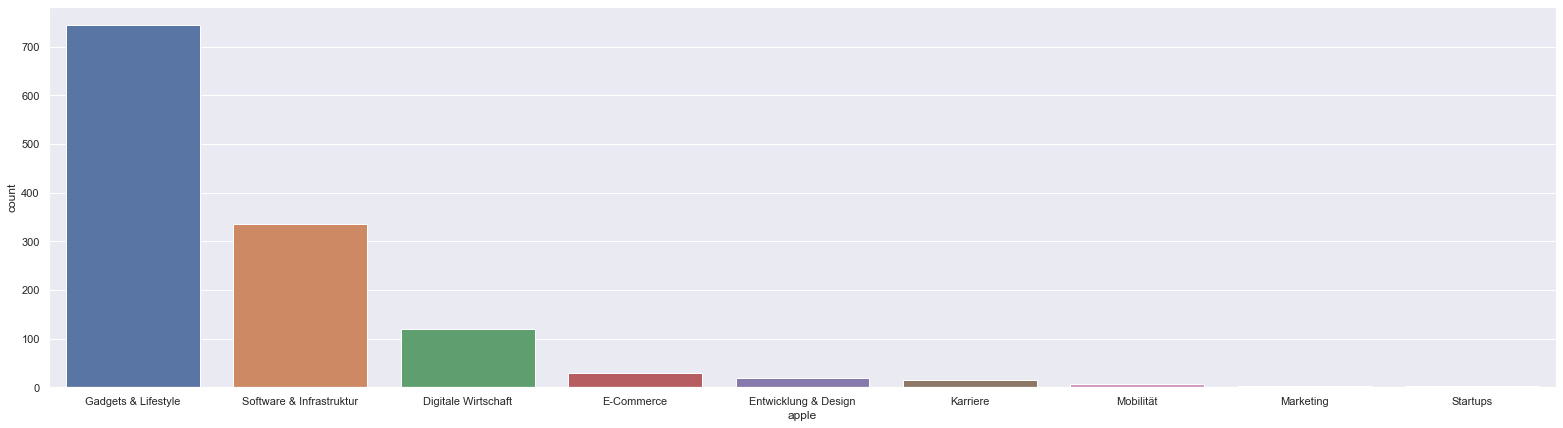

In [103]:
# restriction to Apple
cursor.execute('select top 10 category, count(*) from "$TA_T3NTEXTIND", "T3N" where "$TA_T3NTEXTIND".ID = "T3N".ID and "$TA_T3NTEXTIND".TA_TOKEN = \'Apple\' and TA_TYPE=\'noun\' group by TA_TOKEN, CATEGORY order by count(*) desc')
plot_sql(cursor, "apple")

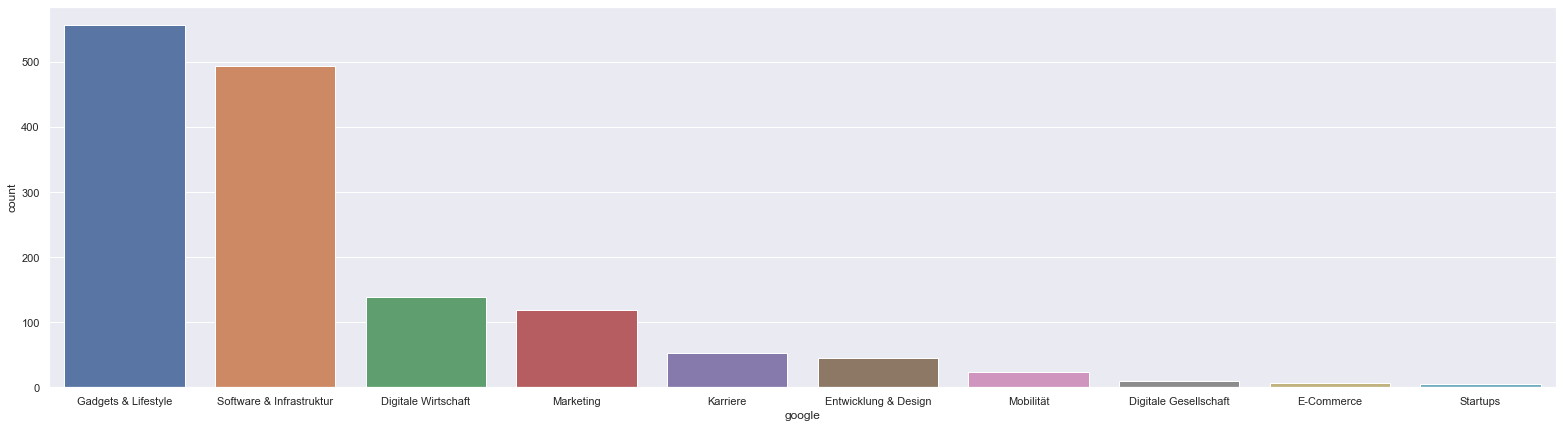

In [102]:
# restriction to Google
cursor.execute('select top 10 category, count(*) from "$TA_T3NTEXTIND", "T3N" where "$TA_T3NTEXTIND".ID = "T3N".ID and "$TA_T3NTEXTIND".TA_TOKEN = \'Google\' and TA_TYPE=\'noun\' group by TA_TOKEN, CATEGORY order by count(*) desc')
plot_sql(cursor, "google")

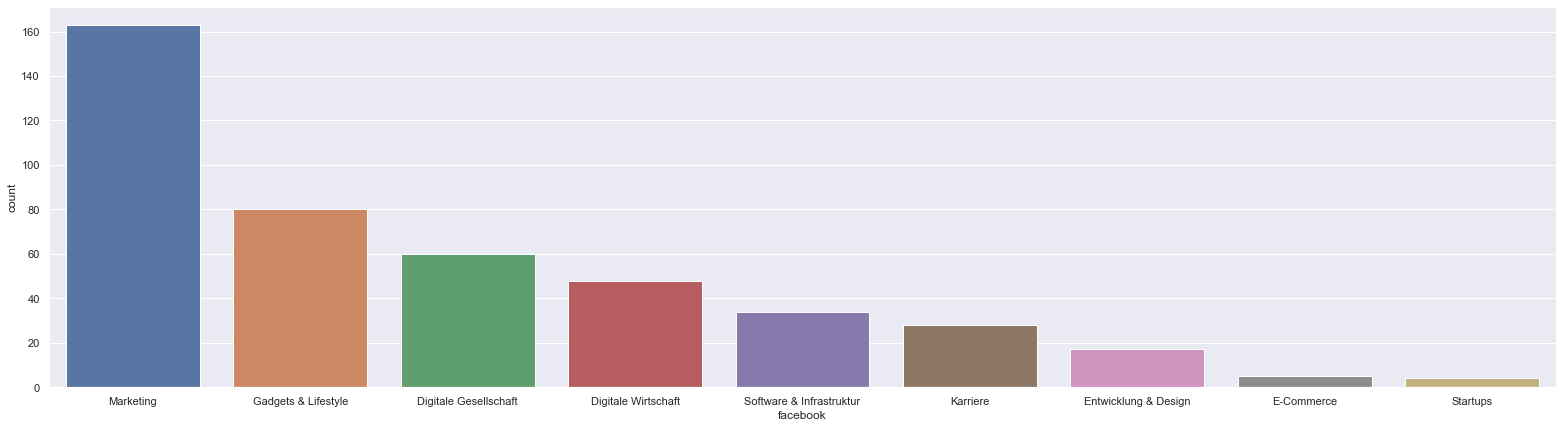

In [101]:
# restriction to Facebook
cursor.execute('select top 10 category, count(*) from "$TA_T3NTEXTIND", "T3N" where "$TA_T3NTEXTIND".ID = "T3N".ID and "$TA_T3NTEXTIND".TA_TOKEN = \'Facebook\' and TA_TYPE=\'noun\' group by TA_TOKEN, CATEGORY order by count(*) desc')
plot_sql(cursor, "facebook")

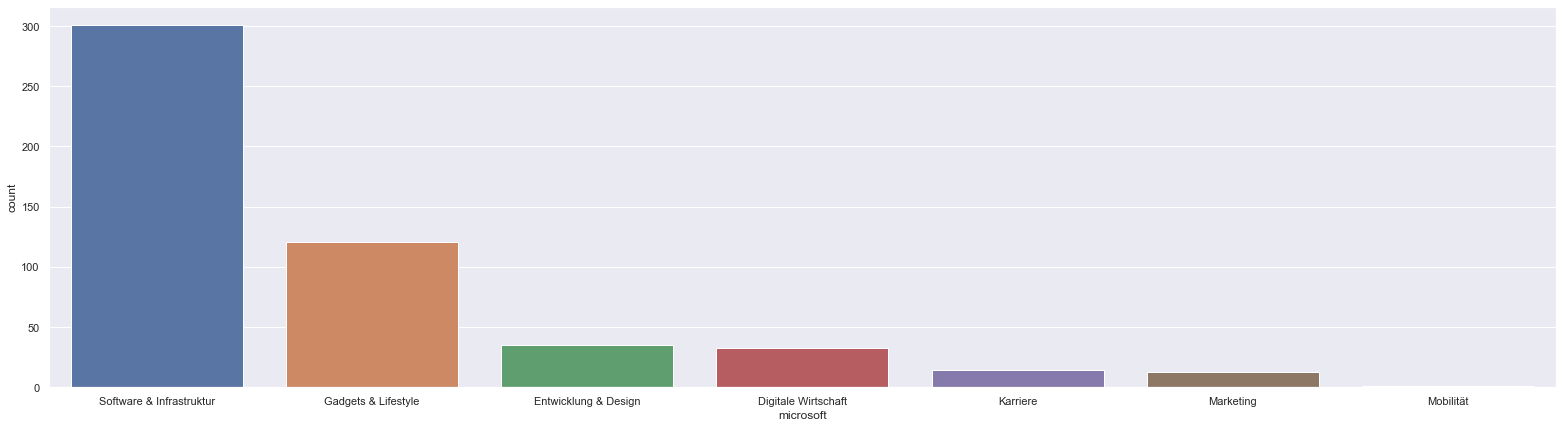

In [99]:
# restriction to Microsoft
cursor.execute('select top 10 category, count(*) from "$TA_T3NTEXTIND", "T3N" where "$TA_T3NTEXTIND".ID = "T3N".ID and "$TA_T3NTEXTIND".TA_TOKEN = \'Microsoft\' and TA_TYPE=\'noun\' group by TA_TOKEN, CATEGORY order by count(*) desc')
plot_sql(cursor, "microsoft")

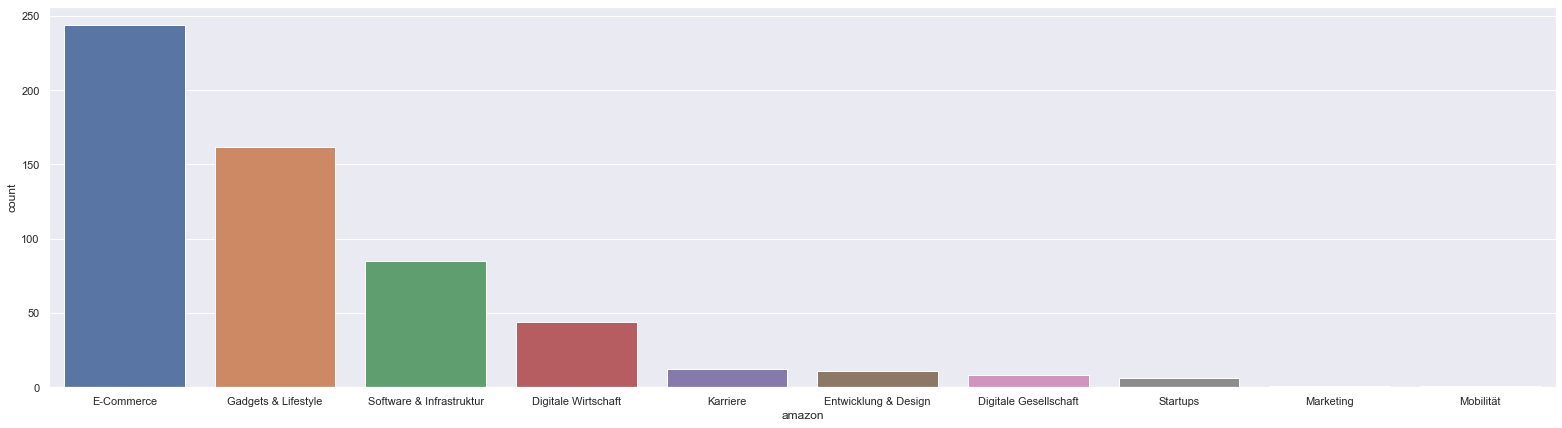

In [100]:
# restriction to Amazon
cursor.execute('select top 10 category, count(*) from "$TA_T3NTEXTIND", "T3N" where "$TA_T3NTEXTIND".ID = "T3N".ID and "$TA_T3NTEXTIND".TA_TOKEN = \'Amazon\' and TA_TYPE=\'noun\' group by TA_TOKEN, CATEGORY order by count(*) desc')
plot_sql(cursor, "amazon")